# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**
##### *Model Building Notebook*

## 1. Libraries

In [5]:
# ! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl prophet lightgbm

# # Tensorflow for CPU users
# ! pip install tensorflow
# ! pip install EMD-signal --quiet

In [6]:
import itertools
import logging
import random
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from PyEMD import EEMD

import os, joblib
import openpyxl

import tensorflow as tf

import keras
from pathlib import Path

from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import windows, savgol_filter
from scipy.stats import boxcox, norm

# Deep learning
from keras.models import Sequential
from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Bidirectional

from prophet import Prophet
# Disable Prophet logs
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

import lightgbm as lgb
# Optional: Disable LightGBM info messages
lgb.basic_config = {'verbose': -1}

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [7]:
# Reproducibility Setup
SEED = 42

# Python random seed
random.seed(SEED)

# NumPy seed
np.random.seed(SEED)

# TensorFlow seed
tf.random.set_seed(SEED)

# For reproducibility in TensorFlow (disable nondeterministic ops)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Disable TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Importing Final Datasts

In [24]:
# Folder containing the datasets
input_folder = Path("final_datasets")

# Dictionary to hold the loaded DataFrames
loaded_dfs = {}

# Loop through all Excel files except 'final_df.xlsx'
for file in input_folder.glob("*.xlsx"):
    if file.name == "final_df.xlsx":
        continue
    
    # Use the filename without extension as the variable name
    var_name = file.stem
    loaded_dfs[var_name] = pd.read_excel(file, index_col=0)  # preserve index if any

# Optionally, assign to variables in global namespace (careful with this in scripts)
globals().update(loaded_dfs)

# Check loaded DataFrames
print("Loaded datasets:")
for name, df in loaded_dfs.items():
    print(f"- {name}: {df.shape}")

Loaded datasets:
- X1_test: (42, 6)
- X1_train: (213, 6)
- X2_test: (42, 2)
- X2_train: (214, 2)
- y1_test: (42, 1)
- y1_train: (213, 1)
- y2_test: (42, 1)
- y2_train: (214, 1)


## 3. Ensemble Empirical Mode Decomposition (EEMD)

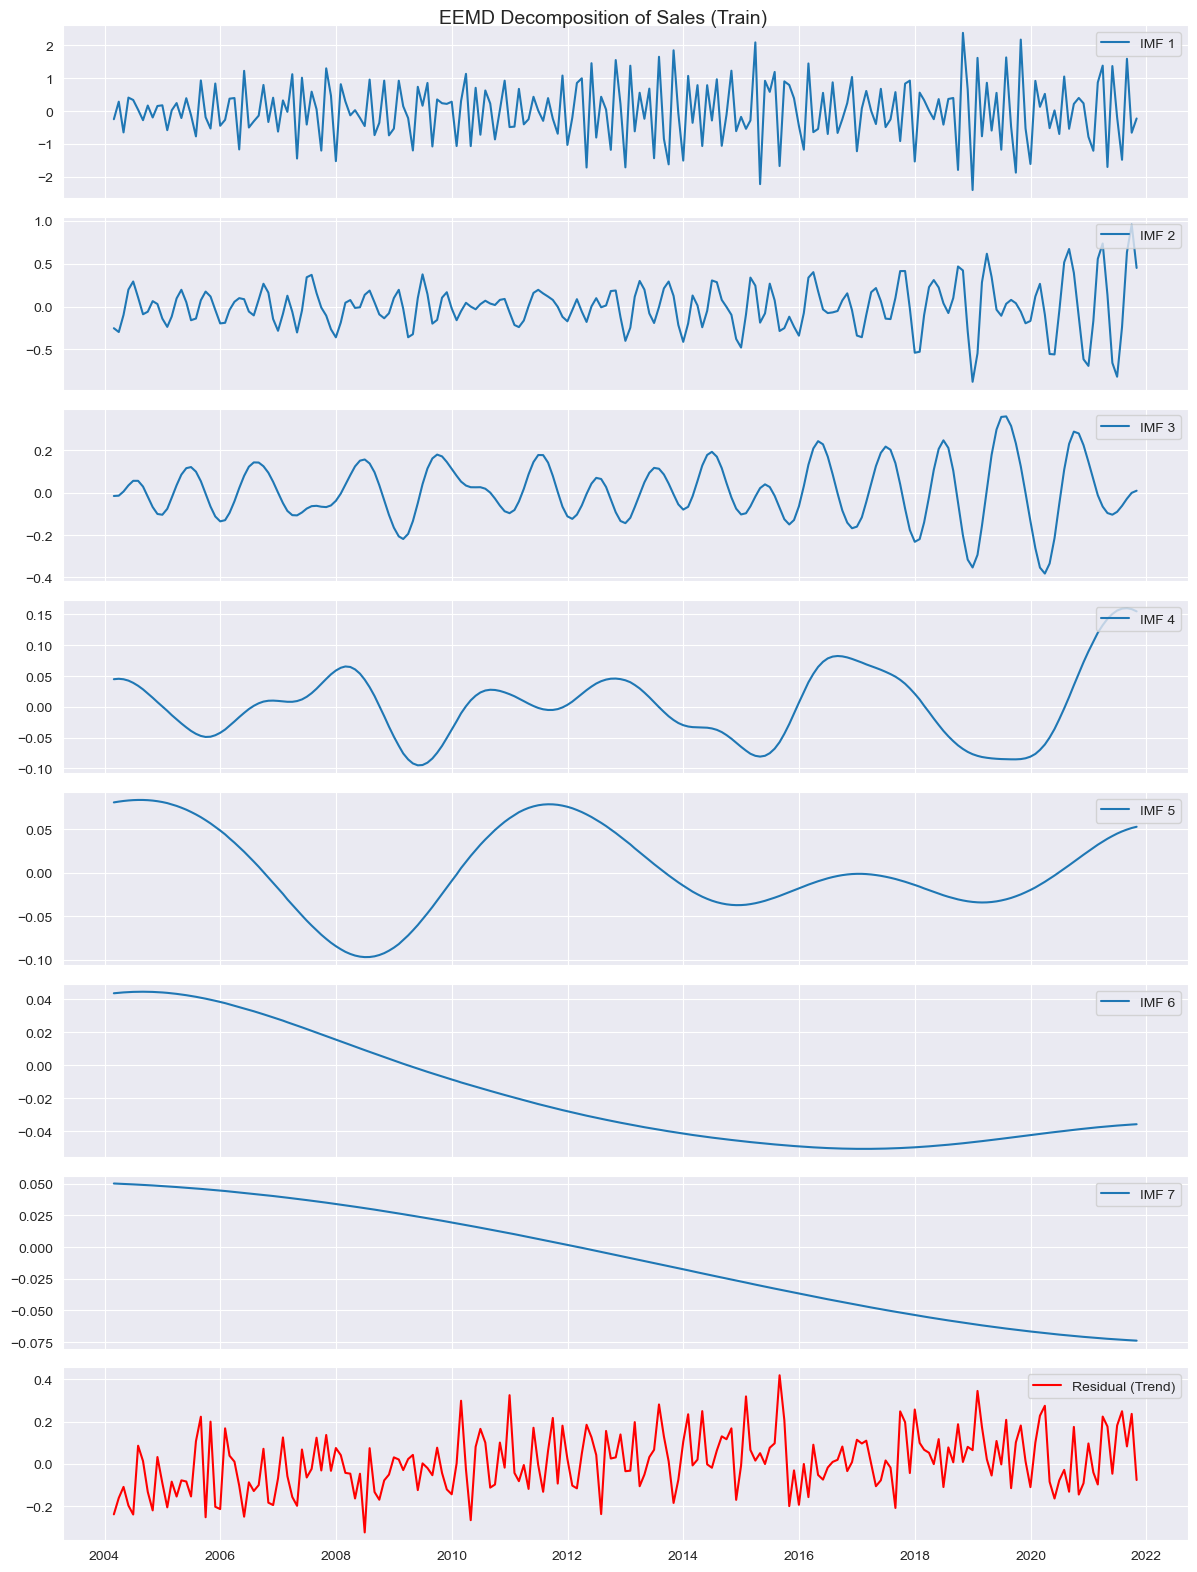

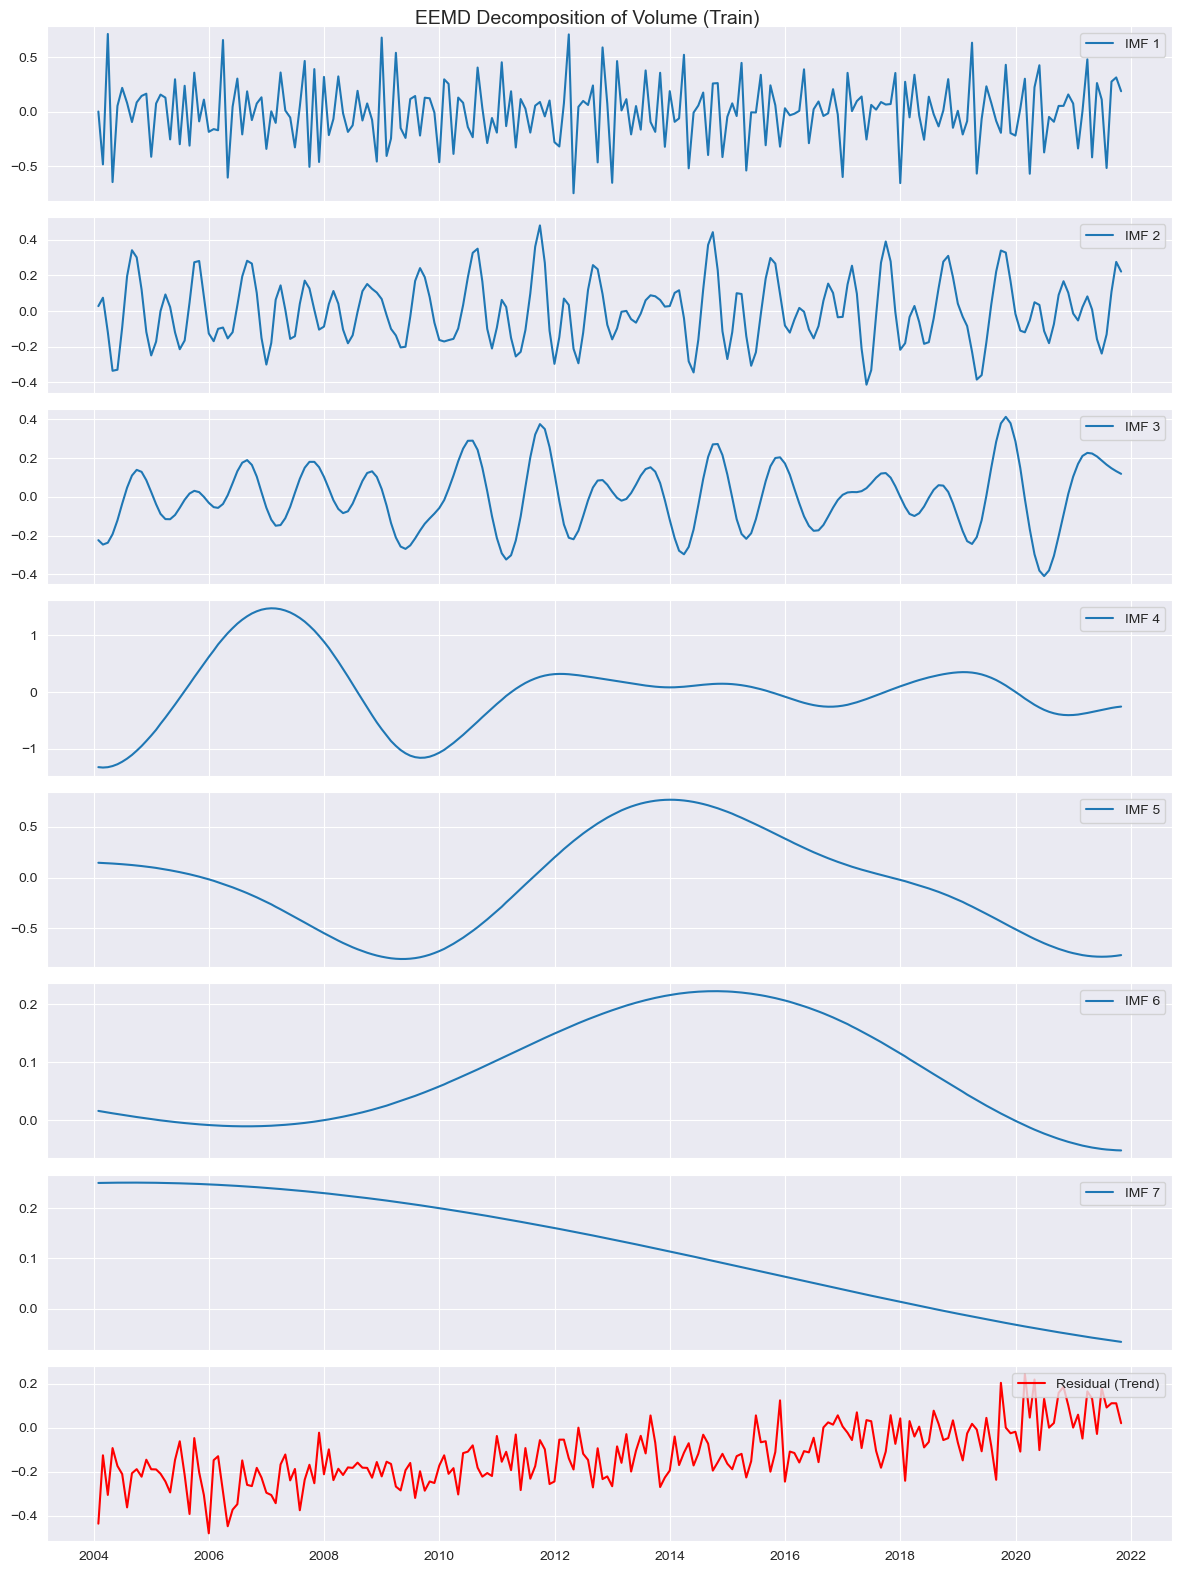

In [ ]:
# === EEMD to create Intrinsic Mode Functions (IMFs) ===

def run_eemd(series, series_name="Series", noise_width=0.2, n_ensembles=100, max_imf=8):
    """
    Run EEMD on a given series (train set only).
    
    Parameters
    ----------
    series : pd.Series
        The time series to decompose.
    series_name : str
        Name of the series (for saving/plotting).
    noise_width : float
        Noise width for EEMD (default = 0.2).
    n_ensembles : int
        Number of ensembles (default = 100).
    max_imf : int
        Max number of IMFs to extract (default = 8).
    
    Returns
    -------
    imfs : np.ndarray
        Array of IMFs (shape: [n_imfs, len(series)]).
    residual : np.ndarray
        Residual component (trend).
    """
    eemd = EEMD()
    eemd.noise_width = noise_width
    eemd.trials = n_ensembles
    
    X = series.values
    t = np.arange(len(X))
    
    # Run EEMD
    imfs = eemd.eemd(X, t, max_imf)
    residual = X - np.sum(imfs, axis=0)
    
    # Plot decomposition
    n_imfs = imfs.shape[0]
    fig, axes = plt.subplots(n_imfs+1, 1, figsize=(12, 2*(n_imfs+1)), sharex=True)
    
    for i in range(n_imfs):
        axes[i].plot(series.index, imfs[i], label=f'IMF {i+1}')
        axes[i].legend(loc='upper right')
    axes[-1].plot(series.index, residual, label="Residual (Trend)", color="red")
    axes[-1].legend(loc='upper right')
    
    plt.suptitle(f"EEMD Decomposition of {series_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return imfs, residual


# === Apply to y1_train (Sales) and y2_train (Volume) ===
sales_imfs, sales_residual = run_eemd(y1_train, series_name="Sales (Train)", noise_width=0.2, n_ensembles=100, max_imf=8)
volume_imfs, volume_residual = run_eemd(y2_train, series_name="Volume (Train)", noise_width=0.2, n_ensembles=100, max_imf=8)

# Store in dicts for later use
eemd_results = {
    "sales": {"imfs": sales_imfs, "residual": sales_residual},
    "volume": {"imfs": volume_imfs, "residual": volume_residual}
}

## 4. 

## 4. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA</td>
      <td>Seasonal ARIMA without exogenous features. Captures linear seasonality and trend but limited in handling nonlinear patterns.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>SARIMAX</td>
      <td>SARIMA + Google Trends as exogenous regressors. Incorporates external signals (e.g., search behavior) to improve predictive accuracy.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>Least Squares SVM regression. Strong at capturing nonlinear relationships, though it requires careful hyperparameter tuning.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>Sequential neural model for time series. Learns long-term dependencies and nonlinearities but can be computationally heavy.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BiLSTM</td>
      <td>Captures both forward and backward dependencies in sequences, offering richer temporal context than unidirectional LSTM.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines CNN (local feature extraction) with LSTM (temporal learning). Effective for complex time series with both short- and long-term dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>GRU</td>
      <td>A simplified version of LSTM with fewer parameters. Trains faster while retaining the ability to model temporal dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>Prophet</td>
      <td>Additive time series model developed by Facebook. Designed for business forecasting, handles seasonality, holidays, and missing data robustly.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LightGBM</td>
      <td>Gradient boosting framework optimized for speed and efficiency. Handles high-dimensional data well, supports feature importance analysis, and is strong at capturing nonlinear interactions.</td>
      <td>Machine Learning</td>
    </tr>
  </tbody>
</table>


### a. Helper Functions

In [ ]:
# ---------------------------
# FULL UPDATED HELPER FUNCTIONS
# ---------------------------

# ---------------------------
# Utility: lag creators
# ---------------------------

# Example: different lags for different targets
lag_config = {
    "Sales": 1,   # national sales remembers 1 step
    "Volume": 2   # volume remembers ~2 steps
}

def create_lags(y, lags=12):
    """Return DataFrame with column 'y' and lag_1..lag_lags, dropping NA."""
    df = pd.DataFrame({'y': np.asarray(y).flatten()})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    return df.dropna()


def create_multivariate_lags(X, y, lags=12):
    """
    Create 3D array X_lagged with shape (n_samples, lags, n_features)
    and vector y_lagged aligned to those windows.
    """
    X_lagged, y_lagged = [], []
    X = np.asarray(X)
    y = np.asarray(y).flatten()
    for i in range(lags, len(X)):
        X_lagged.append(X[i-lags:i, :])
        y_lagged.append(y[i])
    return np.array(X_lagged), np.array(y_lagged)

# ---------------------------
# Residual-based confidence interval utility
# ---------------------------
def compute_residual_ci(y_train, y_pred, alpha=0.05):
    """
    Approximate symmetric CI around y_pred using residual std from aligned tail of y_train.
    Handles differing lengths by aligning the last min(len(y_train), len(y_pred)) points.
    Returns arrays lower, upper of same length as y_pred.
    """
    y_train = np.asarray(y_train).flatten()
    y_pred = np.asarray(y_pred).flatten()
    if len(y_train) == 0:
        sigma = 0.0
    else:
        m = min(len(y_train), len(y_pred))
        if m <= 1:
            resid = y_train[-m:] - y_pred[:m] if m == 1 else np.array([0.0])
            sigma = np.std(resid) if len(resid) > 0 else 0.0
        else:
            resid = y_train[-m:] - y_pred[:m]
            sigma = np.std(resid, ddof=1)
    z = 1.96  # approx for 95% CI
    lower = y_pred - z * sigma
    upper = y_pred + z * sigma
    return lower, upper

def create_forecast_df(forecast_tuple, test_index):
    """
    Convert forecast tuple into a DataFrame with prediction, lower_CI, upper_CI.
    
    forecast_tuple: (predictions, (lower_CI, upper_CI))
    test_index: pd.DatetimeIndex or other index for the test set
    """
    preds = forecast_tuple[0]
    
    # Some models might not have CI, set as NaN
    lower_ci, upper_ci = (None, None)
    if forecast_tuple[1] is not None:
        lower_ci, upper_ci = forecast_tuple[1]
    
    # If CI is None, fill with NaNs
    if lower_ci is None or upper_ci is None:
        lower_ci = [float("nan")] * len(preds)
        upper_ci = [float("nan")] * len(preds)
    
    df = pd.DataFrame({
        "prediction": preds,
        "lower_CI": lower_ci,
        "upper_CI": upper_ci
    }, index=test_index)
    
    return df

# ---------------------------
# Metrics & evaluation
# ---------------------------
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    resid = np.asarray(y_true).flatten() - np.asarray(y_pred).flatten()[:n]
    sigma2 = np.var(resid) if np.var(resid) > 0 else 1e-8
    loglik = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * k - 2 * loglik
    bic = np.log(n) * k - 2 * loglik
    return aic, bic

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).flatten(), np.array(y_pred).flatten()[:len(y_true)]
    denom = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom))

def evaluate_model(name, y_true, y_pred, k):
    """
    Return list matching your results table columns:
    [name, AIC, BIC, RMSE, MAE, MAPE, R2] rounded to 2 decimal places
    """
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()[:len(y_true)]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    aic, bic = calculate_aic_bic(y_true, y_pred, k)

    # Round all metrics to 2 decimals
    return [name,
            round(float(aic), 2),
            round(float(bic), 2),
            round(float(rmse), 2),
            round(float(mae), 2),
            round(float(mape), 2),
            round(float(r2), 2)]

# ---------------------------
# Baseline model training functions
# --------------------------
def train_sarima(y, order=(0,1,1), seasonal_order=(0,0,2,12), steps=12, trend="t"):
    """
    Fit SARIMAX on y (1D array-like). Return (results, forecast, (lower, upper))
    """
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast_obj = results.get_forecast(steps=steps)
    forecast = np.asarray(forecast_obj.predicted_mean)
    ci = np.asarray(forecast_obj.conf_int()).T
    lower, upper = ci[0], ci[1]
    return results, forecast, (lower, upper)

def train_sarimax(y, exog, exog_future, order=(0,1,1), seasonal_order=(0,0,2,12), steps=12, trend="t"):
    """
    Fit SARIMAX with exogenous variables.
    y: 1d array-like (train)
    exog: 2D array-like aligned to y
    exog_future: 2D array-like for forecast horizon
    """
    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    forecast_obj = results.get_forecast(steps=steps, exog=exog_future)
    forecast = np.asarray(forecast_obj.predicted_mean)
    ci = np.asarray(forecast_obj.conf_int()).T
    lower, upper = ci[0], ci[1]
    return results, forecast, (lower, upper)

def train_svr(X_train, y_train, X_test, kernel="rbf", C=1.0, gamma="scale"):
    """
    Train SVR on X_train/y_train and predict on X_test.
    Returns (model, forecast, (lower, upper)) where CI is approximated from train residuals.
    """
    model = SVR(kernel=kernel, C=C, gamma=gamma)
    model.fit(np.asarray(X_train), np.asarray(y_train).ravel())
    forecast = model.predict(np.asarray(X_test))
    lower, upper = compute_residual_ci(y_train, model.predict(X_train))
    # Broadcast to test horizon in a stable way
    lower = np.repeat(np.mean(lower), len(forecast)) + (forecast - np.mean(forecast))
    upper = np.repeat(np.mean(upper), len(forecast)) + (forecast - np.mean(forecast))
    return model, np.asarray(forecast), (lower, upper)

def train_svr_multivariate(X_train, y_train, X_test, kernel="rbf", C=1.0, gamma="scale"):
    return train_svr(X_train, y_train, X_test, kernel=kernel, C=C, gamma=gamma)

# ---------------------------
# Simple NN builder + training wrappers
# ---------------------------
def build_model(model_type, input_shape, units=64, filters=64, kernel_size=3, pool_size=2, lr=0.001, dropout=0.2):
    """
    Build and compile a simple NN for regression:
    - model_type: "lstm", "bilstm", "cnnlstm", "gru"
    - input_shape: (timesteps, features)
    """
    model = Sequential()
    if model_type == "lstm":
        model.add(LSTM(units, activation="tanh", return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(LSTM(max(1, units//2), activation="tanh"))
    elif model_type == "bilstm":
        model.add(Bidirectional(LSTM(units, activation="tanh", return_sequences=True), input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(Bidirectional(LSTM(max(1, units//2), activation="tanh")))
    elif model_type == "cnnlstm":
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape))
        model.add(Conv1D(filters=max(4, filters//2), kernel_size=2, activation="relu"))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))
        model.add(LSTM(units, activation="tanh", return_sequences=True))
        model.add(LSTM(max(1, units//2), activation="tanh"))
    elif model_type == "gru":
        model.add(GRU(units, activation="tanh", return_sequences=True, input_shape=input_shape))
        model.add(Dropout(dropout))
        model.add(GRU(max(1, units//2), activation="tanh"))
    else:
        raise ValueError(f"Unknown model_type '{model_type}'. Supported: lstm, bilstm, cnnlstm, gru")
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

def train_nn_univariate(y_train, y_test, model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    """
    Train a univariate NN using lagged windows and return (model, forecast)
    - y_train: 1D array (training series)
    - y_test: 1D array (test/forecast horizon)
    """
    y_train = np.asarray(y_train).flatten()
    # If training too short, fall back to mean forecast
    if len(y_train) <= lags:
        preds = np.repeat(np.mean(y_train), len(y_test))
        return None, np.asarray(preds)

    # Build lagged training matrix
    X_train = np.array([y_train[i-lags:i] for i in range(lags, len(y_train))])
    y_train_lag = y_train[lags:]
    X_train = X_train.reshape(-1, lags, 1)

    model = build_model(model_type, (lags, 1), **kwargs)
    model.fit(X_train, y_train_lag, epochs=epochs, batch_size=batch_size, verbose=0)

    # recursive forecast (auto-regressive)
    forecast = []
    last_window = list(y_train[-lags:])
    for _ in range(len(y_test)):
        x_in = np.array(last_window[-lags:]).reshape(1, lags, 1)
        yhat = float(model.predict(x_in, verbose=0)[0, 0])
        forecast.append(yhat)
        last_window.append(yhat)

    forecast = np.asarray(forecast)
    return model, forecast

def train_nn_univariate_series(y_train, y_test, series_name, lag_config,
                               model_type="lstm", epochs=20, batch_size=16, **kwargs):
    lags = lag_config.get(series_name, 12)
    return train_nn_univariate(y_train, y_test, model_type=model_type,
                               lags=lags, epochs=epochs, batch_size=batch_size, **kwargs)


def train_nn_multivariate_direct(X_train_lagged, y_train_lagged, X_train_full, X_test_full,
                                 model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    """
    Train a multivariate NN on 3D X_train_lagged (n_samples, lags, n_feats) and y_train_lagged (vector)
    Returns (model, preds) where preds is length = X_test_full.shape[0].
    """
    if X_train_lagged.shape[0] == 0:
        return None, np.repeat(np.mean(y_train_lagged), X_test_full.shape[0])

    model = build_model(model_type, (X_train_lagged.shape[1], X_train_lagged.shape[2]), **kwargs)
    model.fit(X_train_lagged, y_train_lagged, epochs=epochs, batch_size=batch_size, verbose=0)

    # Build rolling windows from exogenous seed + test exog (seed = last lags of X_train_full)
    def build_test_windows_from_exog(X_train_full, X_test_full, lags):
        seed_plus_test = np.vstack([X_train_full[-lags:, :], X_test_full])
        return np.array([seed_plus_test[i:i+lags, :] for i in range(len(X_test_full))])

    X_test_windows = build_test_windows_from_exog(X_train_full, X_test_full, lags)
    preds = model.predict(X_test_windows, verbose=0).flatten()
    return model, np.asarray(preds)

def train_nn_multivariate_series(X_train, y_train, X_test, series_name, lag_config,
                                 model_type="lstm", epochs=20, batch_size=16, **kwargs):
    lags = lag_config.get(series_name, 12)
    X_train_lagged, y_train_lagged = create_multivariate_lags(X_train, y_train, lags=lags)
    return train_nn_multivariate_direct(X_train_lagged, y_train_lagged,
                                        X_train, X_test,
                                        model_type=model_type, lags=lags,
                                        epochs=epochs, batch_size=batch_size, **kwargs)

# ---------------------------
# EEMD helpers
# ---------------------------
def apply_eemd(series, ensemble_size=50, noise_strength=0.2):
    """
    Return IMFs array (list of arrays) for the provided 1D series.
    Uses PyEMD.EEMD(trials=ensemble_size, noise_width=noise_strength).
    """
    series = np.asarray(series).flatten()
    eemd = EEMD(trials=ensemble_size, noise_width=noise_strength)
    IMFs = eemd.eemd(series)
    return IMFs

def _extract_preds_from_model_func_output(outputs, expected_len):
    """
    Accept outputs like: (model, preds), (model, preds, extra), preds array, or pandas Series.
    Return flattened numpy preds of length expected_len (or trim/pad if necessary).
    """
    # find first array-like in output tuple/list (search from end to prefer preds)
    preds = None
    if isinstance(outputs, (tuple, list)):
        for el in reversed(outputs):
            if isinstance(el, (np.ndarray, list, pd.Series)):
                preds = np.asarray(el).flatten()
                break
        if preds is None:
            # fallback to second element or first
            try:
                preds = np.asarray(outputs[1]).flatten()
            except Exception:
                preds = np.asarray(outputs[0]).flatten()
    elif isinstance(outputs, (np.ndarray, list, pd.Series)):
        preds = np.asarray(outputs).flatten()
    else:
        preds = np.asarray(outputs).flatten()

    # Trim or pad
    if len(preds) >= expected_len:
        return preds[:expected_len]
    else:
        if len(preds) == 0:
            return np.zeros(expected_len)
        pad = np.full(expected_len - len(preds), preds[-1])
        return np.concatenate([preds, pad])

def forecast_with_eemd_univariate(y_train, y_test, model_func, k, name,
                                  ensemble_size=50, noise_strength=0.2, alpha=0.05, return_forecast=False, **kwargs):
    """
    Decompose the concatenated series (y_train + y_test) with EEMD, fit model_func on each IMF
    (train_part, test_part) and sum the forecasts and the CI bands.
    model_func signature (train_part, test_part, **kwargs) -> (model, preds) or (model, preds, (lower, upper)) or preds
    Returns:
      - if return_forecast: (evaluate_model(...), (recon_preds, (recon_lower, recon_upper)))
      - else: evaluate_model(...)
    """
    # Decompose full series so that IMFs include both train and test parts
    series_full = np.concatenate([np.asarray(y_train).flatten(), np.asarray(y_test).flatten()])
    IMFs = apply_eemd(series_full, ensemble_size=ensemble_size, noise_strength=noise_strength)

    recon_preds = np.zeros(len(y_test))
    recon_lower = np.zeros(len(y_test))
    recon_upper = np.zeros(len(y_test))

    for imf in IMFs:
        imf = np.asarray(imf).flatten()
        if len(imf) != len(series_full):
            # skip irregular imfs
            continue

        # split into train/test
        train_part = imf[:-len(y_test)]
        test_part = imf[-len(y_test):]

        outputs = model_func(train_part, test_part, **kwargs)

        # Handle different return signatures
        if isinstance(outputs, (tuple, list)) and len(outputs) >= 3:
            preds = np.asarray(outputs[1]).flatten()
            lower, upper = outputs[2]
        else:
            preds = _extract_preds_from_model_func_output(outputs, len(y_test))
            lower, upper = compute_residual_ci(train_part, preds, alpha=alpha)

        preds = preds[:len(y_test)]
        lower = np.asarray(lower)[:len(y_test)]
        upper = np.asarray(upper)[:len(y_test)]

        recon_preds += preds
        recon_lower += lower
        recon_upper += upper

    eval_metrics = evaluate_model(name, y_test, recon_preds, k)
    if return_forecast:
        return eval_metrics, (recon_preds, (recon_lower, recon_upper))
    return eval_metrics

def forecast_with_eemd_multivariate(X_train, X_test, y_train, y_test, model_func, k, name,
                                    ensemble_size=50, noise_strength=0.2, alpha=0.05, return_forecast=False, **kwargs):
    """
    Decompose y (train+test) with EEMD, for each IMF fit model_func
    model_func(Xtr_aligned, ytr_imf, Xte, **kwargs) -> (model, preds) or (model, preds, (lower,upper)) or preds
    Returns evaluate_model(...) or (evaluate_model, (recon_preds,(lower,upper))) when return_forecast=True
    """
    series_full = np.concatenate([np.asarray(y_train).flatten(), np.asarray(y_test).flatten()])
    IMFs = apply_eemd(series_full, ensemble_size=ensemble_size, noise_strength=noise_strength)

    recon_preds = np.zeros(len(y_test))
    recon_lower = np.zeros(len(y_test))
    recon_upper = np.zeros(len(y_test))

    for imf in IMFs:
        imf = np.asarray(imf).flatten()
        if len(imf) != len(series_full):
            continue

        train_part = imf[:-len(y_test)]
        # Align X_train to the length of train_part (usually full X_train)
        if X_train.shape[0] < len(train_part):
            # can't align; skip
            continue
        X_train_aligned = X_train[-len(train_part):, :]

        outputs = model_func(X_train_aligned, train_part, X_test, **kwargs)

        if isinstance(outputs, (tuple, list)) and len(outputs) >= 3:
            preds = np.asarray(outputs[1]).flatten()
            lower, upper = outputs[2]
        else:
            preds = _extract_preds_from_model_func_output(outputs, len(y_test))
            lower, upper = compute_residual_ci(train_part, preds, alpha=alpha)

        preds = preds[:len(y_test)]
        lower = np.asarray(lower)[:len(y_test)]
        upper = np.asarray(upper)[:len(y_test)]

        recon_preds += preds
        recon_lower += lower
        recon_upper += upper

    eval_metrics = evaluate_model(name, y_test, recon_preds, k)
    if return_forecast:
        return eval_metrics, (recon_preds, (recon_lower, recon_upper))
    return eval_metrics

# ---------------------------
# Wrappers for univariate models (for EEMD usage)
# ---------------------------
def sarima_wrapper_univariate(y_train_tr, y_test_te, order=(0,1,1), seasonal_order=(0,0,2,12), **kwargs):
    results, preds, ci = train_sarima(y_train_tr, order=order, seasonal_order=seasonal_order, steps=len(y_test_te))
    return (results, np.asarray(preds), ci)

def svr_univariate_wrapper(y_train_tr, y_test_te, lags=12, **svr_kwargs):
    """
    Build lag features on the IMF train part, fit SVR, then recursively forecast for len(y_test_te).
    """
    y_train_tr = np.asarray(y_train_tr).flatten()
    if len(y_train_tr) <= lags:
        return (None, np.repeat(np.mean(y_train_tr), len(y_test_te)))
    df = create_lags(y_train_tr, lags=lags)
    X_tr = df.drop("y", axis=1).values
    y_tr = df["y"].values
    model = SVR(**{k: v for k, v in svr_kwargs.items() if k in ['kernel', 'C', 'gamma']})
    model.fit(X_tr, y_tr)
    last_window = list(y_train_tr[-lags:])
    preds = []
    for _ in range(len(y_test_te)):
        x_in = np.array(last_window[-lags:]).reshape(1, -1)
        yhat = float(model.predict(x_in)[0])
        preds.append(yhat)
        last_window.append(yhat)
    return (model, np.asarray(preds))

# Safe wrapper for train_svr (keeps compatibility)
def call_train_svr(X_train, y_train, X_test):
    out = train_svr(X_train, y_train, X_test)
    if isinstance(out, tuple) and len(out) >= 2:
        return out[0], out[1]  # (model, forecast)
    else:
        return None, out       # forecast only

# Safe wrapper for train_svr_multivariate
def call_train_svr_multi(X_train, y_train, X_test):
    out = train_svr_multivariate(X_train, y_train, X_test)
    if isinstance(out, tuple) and len(out) >= 2:
        return out[0], out[1]
    else:
        return None, out

def nn_univariate_wrapper(y_train_tr, y_test_te, model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    """
    Return (model, preds) for use inside EEMD univariate wrapper.
    """
    return train_nn_univariate(y_train_tr, y_test_te, model_type=model_type, lags=lags, epochs=epochs, batch_size=batch_size, **kwargs)

# ---------------------------
# Wrappers for multivariate models (for EEMD usage)
# model_func expected signature: fn(X_train_aligned, y_train_imf, X_test)
# ---------------------------
def sarimax_multivariate_wrapper(Xtr_aligned, ytr_imf, Xte, order=(0,1,1), seasonal_order=(0,0,2,12), **kwargs):
    _, preds, ci = train_sarimax(ytr_imf, Xtr_aligned, Xte, order=order, seasonal_order=seasonal_order, steps=Xte.shape[0])
    return (None, np.asarray(preds), ci)

def svr_multivariate_wrapper(Xtr_aligned, ytr_imf, Xte, **svr_kwargs):
    model = SVR(**{k:v for k,v in svr_kwargs.items() if k in ['kernel','C','gamma']})
    model.fit(np.asarray(Xtr_aligned), np.asarray(ytr_imf).ravel())
    preds = model.predict(np.asarray(Xte))
    return (model, np.asarray(preds))

def nn_multivariate_wrapper(Xtr_aligned, ytr_imf, Xte, model_type="lstm", lags=12, epochs=20, batch_size=16, **kwargs):
    """
    Build lagged arrays from Xtr_aligned & ytr_imf and call the NN multivariate direct trainer.
    Returns (model, preds).
    """
    Xtr_lagged, ytr_lagged = create_multivariate_lags(Xtr_aligned, ytr_imf, lags=lags)
    if Xtr_lagged.shape[0] == 0:
        return (None, np.repeat(np.mean(ytr_imf), Xte.shape[0]))
    model, preds = train_nn_multivariate_direct(Xtr_lagged, ytr_lagged, Xtr_aligned, Xte,
                                                model_type=model_type, lags=lags, epochs=epochs, batch_size=batch_size, **kwargs)
    return (model, np.asarray(preds))

# ---------------------------
# Prophet & LightGBM wrappers (extended with missing EEMD versions)
# ---------------------------

def prophet_univariate_wrapper(y_train_tr, y_test_te, freq='D', start_date='2000-01-01', **kwargs):
    """
    Fit Prophet on y_train_tr and forecast len(y_test_te).
    Returns (model, preds)
    """
    y_train_tr = np.asarray(y_train_tr).flatten()
    df_train = pd.DataFrame({
        "ds": pd.date_range(start=start_date, periods=len(y_train_tr), freq=freq),
        "y": y_train_tr
    })
    model = Prophet()
    model.fit(df_train)
    future = pd.DataFrame({
        "ds": pd.date_range(
            start=df_train["ds"].iloc[-1] + pd.Timedelta(1, unit=freq.lower()),
            periods=len(y_test_te),
            freq=freq
        )
    })
    forecast_df = model.predict(future)
    preds = forecast_df["yhat"].values
    return model, np.asarray(preds)


def prophet_multivariate_wrapper(Xtr_aligned, ytr_imf, Xte, freq='D', start_date='2000-01-01', **kwargs):
    """
    Prophet multivariate is not native; we approximate by fitting Prophet on target only.
    Exogenous features ignored, same as univariate Prophet but aligned with multi-EEMD setup.
    """
    ytr_imf = np.asarray(ytr_imf).flatten()
    df_train = pd.DataFrame({
        "ds": pd.date_range(start=start_date, periods=len(ytr_imf), freq=freq),
        "y": ytr_imf
    })
    model = Prophet()
    model.fit(df_train)
    future = pd.DataFrame({
        "ds": pd.date_range(
            start=df_train["ds"].iloc[-1] + pd.Timedelta(1, unit=freq.lower()),
            periods=Xte.shape[0],
            freq=freq
        )
    })
    forecast_df = model.predict(future)
    preds = forecast_df["yhat"].values
    return model, np.asarray(preds)


def lgb_univariate_wrapper(y_train_tr, y_test_te, lags=12, lgb_params=None):
    """
    Train LightGBM using lag features on y_train_tr and forecast recursively.
    Returns (model, preds)
    """
    y_train_tr = np.asarray(y_train_tr).flatten()
    if len(y_train_tr) <= lags:
        return None, np.repeat(np.mean(y_train_tr), len(y_test_te))
    df = create_lags(y_train_tr, lags=lags)
    X_tr = df.drop("y", axis=1).values
    y_tr = df["y"].values
    model = lgb.LGBMRegressor(**(lgb_params or {}))
    model.fit(X_tr, y_tr)
    last_window = list(y_train_tr[-lags:])
    preds = []
    for _ in range(len(y_test_te)):
        x_in = np.array(last_window[-lags:]).reshape(1, -1)
        yhat = float(model.predict(x_in)[0])
        preds.append(yhat)
        last_window.append(yhat)
    return model, np.asarray(preds)


def lgb_multivariate_wrapper(Xtr_aligned, ytr_imf, Xte, lgb_params=None):
    """
    Train LightGBM on aligned multivariate data.
    Returns (model, preds)
    """
    model = lgb.LGBMRegressor(**(lgb_params or {}))
    model.fit(np.asarray(Xtr_aligned), np.asarray(ytr_imf).ravel())
    preds = model.predict(np.asarray(Xte))
    return (model, np.asarray(preds))


# ---------------------------
# NEW Wrappers for Prophet & LightGBM + EEMD
# ---------------------------

def prophet_univariate_eemd_wrapper(y_train_tr, y_test_te, **kwargs):
    """
    Wrapper for Prophet with EEMD decomposition.
    """
    return forecast_with_eemd_univariate(
        y_train_tr, y_test_te, prophet_univariate_wrapper,
        k=1, name="PROPHET-Uni_EEMD", **kwargs
    )


def prophet_multivariate_eemd_wrapper(Xtr, Xte, ytr, yte, **kwargs):
    """
    Wrapper for Prophet multivariate with EEMD decomposition.
    """
    return forecast_with_eemd_multivariate(
        Xtr, Xte, ytr, yte, prophet_multivariate_wrapper,
        k=1, name="PROPHET-Multi_EEMD", **kwargs
    )


def lgb_univariate_eemd_wrapper(y_train_tr, y_test_te, lags=12, lgb_params=None, **kwargs):
    """
    Wrapper for LightGBM univariate with EEMD decomposition.
    """
    return forecast_with_eemd_univariate(
        y_train_tr, y_test_te,
        lambda train, test, **_: lgb_univariate_wrapper(train, test, lags=lags, lgb_params=lgb_params),
        k=lags, name="LIGHTGBM-Uni_EEMD", **kwargs
    )


def lgb_multivariate_eemd_wrapper(Xtr, Xte, ytr, yte, lgb_params=None, **kwargs):
    """
    Wrapper for LightGBM multivariate with EEMD decomposition.
    """
    return forecast_with_eemd_multivariate(
        Xtr, Xte, ytr, yte,
        lambda Xtrain, ytrain, Xtest, **_: lgb_multivariate_wrapper(Xtrain, ytrain, Xtest, lgb_params=lgb_params),
        k=Xtr.shape[1], name="LIGHTGBM-Multi_EEMD", **kwargs
    )

### b. Sales

#### i. Model Training

In [ ]:
# FULL MODEL TRAINING PIPELINE (Sales)
# ---------------------------

# ---------------------------
# Ensure NumPy arrays
# ---------------------------
y1_train_np = y1_train.values.flatten() if hasattr(y1_train, "values") else y1_train.flatten()
y1_test_np  = y1_test.values.flatten()  if hasattr(y1_test, "values") else y1_test.flatten()
X1_train_np = X1_train.values if hasattr(X1_train, "values") else X1_train
X1_test_np  = X1_test.values  if hasattr(X1_test, "values") else X1_test

lags = 1
epochs = 30
batch_size = 8
ensemble_size = 50
noise_strength = 0.2
alpha = 0.05

# ---------------------------
# Containers
# ---------------------------
results_uni = []
forecasts_uni = {}
results_multi = []
forecasts_multi = {}

# ---------------------------
# ---- UNIVARIATE MODELS ----
# ---------------------------

# SARIMA
_, sarima_forecast, sarima_ci = train_sarima(y1_train_np, steps=len(y1_test_np))
results_uni.append(evaluate_model("SARIMA", y1_test_np, sarima_forecast, k=3))
forecasts_uni["SARIMA"] = (sarima_forecast, sarima_ci)

# LSSVR-Uni
_, lssvr_forecast = call_train_svr(X1_train_np[:, :1], y1_train_np, X1_test_np[:, :1])
lssvr_lower, lssvr_upper = compute_residual_ci(y1_train_np, lssvr_forecast)
results_uni.append(evaluate_model("LSSVR-Uni", y1_test_np, lssvr_forecast, k=1))
forecasts_uni["LSSVR-Uni"] = (lssvr_forecast, (lssvr_lower, lssvr_upper))

# LSTM-Uni
_, lstm_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="lstm",
                                       lags=lags, epochs=epochs, batch_size=batch_size)
lstm_lower, lstm_upper = compute_residual_ci(y1_train_np, lstm_forecast)
results_uni.append(evaluate_model("LSTM-Uni", y1_test_np, lstm_forecast, k=lags+50))
forecasts_uni["LSTM-Uni"] = (lstm_forecast, (lstm_lower, lstm_upper))

# BiLSTM-Uni
_, bilstm_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="bilstm",
                                         lags=lags, epochs=epochs, batch_size=batch_size)
bilstm_lower, bilstm_upper = compute_residual_ci(y1_train_np, bilstm_forecast)
results_uni.append(evaluate_model("BiLSTM-Uni", y1_test_np, bilstm_forecast, k=lags+50))
forecasts_uni["BiLSTM-Uni"] = (bilstm_forecast, (bilstm_lower, bilstm_upper))

# CNN-LSTM-Uni
_, cnnlstm_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="cnnlstm",
                                          lags=lags, epochs=epochs, batch_size=batch_size)
cnnlstm_lower, cnnlstm_upper = compute_residual_ci(y1_train_np, cnnlstm_forecast)
results_uni.append(evaluate_model("CNN-LSTM-Uni", y1_test_np, cnnlstm_forecast, k=lags+50+64))
forecasts_uni["CNN-LSTM-Uni"] = (cnnlstm_forecast, (cnnlstm_lower, cnnlstm_upper))

# GRU-Uni
_, gru_forecast = train_nn_univariate(y1_train_np, y1_test_np, model_type="gru",
                                      lags=lags, epochs=epochs, batch_size=batch_size)
gru_lower, gru_upper = compute_residual_ci(y1_train_np, gru_forecast)
results_uni.append(evaluate_model("GRU-Uni", y1_test_np, gru_forecast, k=lags+50))
forecasts_uni["GRU-Uni"] = (gru_forecast, (gru_lower, gru_upper))

# Prophet-Uni
_, prophet_forecast = prophet_univariate_wrapper(y1_train_np, y1_test_np)
results_uni.append(evaluate_model("PROPHET-Uni", y1_test_np, prophet_forecast, k=3))
forecasts_uni["PROPHET-Uni"] = (prophet_forecast, (None, None))

# LightGBM-Uni
_, lgb_forecast = lgb_univariate_wrapper(y1_train_np, y1_test_np, lags=lags)
lgb_lower, lgb_upper = compute_residual_ci(y1_train_np, lgb_forecast)
results_uni.append(evaluate_model("LIGHTGBM-Uni", y1_test_np, lgb_forecast, k=lags))
forecasts_uni["LIGHTGBM-Uni"] = (lgb_forecast, (lgb_lower, lgb_upper))

# ---------------------------
# ---- MULTIVARIATE MODELS ----
# ---------------------------
X1_train_nn_lagged, y1_train_nn_lagged = create_multivariate_lags(X1_train_np, y1_train_np, lags=lags)

# SARIMAX
_, sarimax_forecast, sarimax_ci = train_sarimax(y1_train_np, X1_train_np, X1_test_np, steps=len(y1_test_np))
results_multi.append(evaluate_model("SARIMAX-Multi", y1_test_np, sarimax_forecast, k=3+X1_train_np.shape[1]))
forecasts_multi["SARIMAX-Multi"] = (sarimax_forecast, sarimax_ci)

# LSSVR-Multi
_, lssvr_mv_forecast = call_train_svr_multi(X1_train_np, y1_train_np, X1_test_np)
lssvr_mv_lower, lssvr_mv_upper = compute_residual_ci(y1_train_np, lssvr_mv_forecast)
results_multi.append(evaluate_model("LSSVR-Multi", y1_test_np, lssvr_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["LSSVR-Multi"] = (lssvr_mv_forecast, (lssvr_mv_lower, lssvr_mv_upper))

# LSTM-Multi
_, lstm_mv_forecast = train_nn_multivariate_direct(X1_train_nn_lagged, y1_train_nn_lagged,
                                                   X1_train_np, X1_test_np,
                                                   model_type="lstm", lags=lags,
                                                   epochs=epochs, batch_size=batch_size)
lstm_mv_lower, lstm_mv_upper = compute_residual_ci(y1_train_np, lstm_mv_forecast)
results_multi.append(evaluate_model("LSTM-Multi", y1_test_np, lstm_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["LSTM-Multi"] = (lstm_mv_forecast, (lstm_mv_lower, lstm_mv_upper))

# BiLSTM-Multi
_, bilstm_mv_forecast = train_nn_multivariate_direct(X1_train_nn_lagged, y1_train_nn_lagged,
                                                     X1_train_np, X1_test_np,
                                                     model_type="bilstm", lags=lags,
                                                     epochs=epochs, batch_size=batch_size)
bilstm_mv_lower, bilstm_mv_upper = compute_residual_ci(y1_train_np, bilstm_mv_forecast)
results_multi.append(evaluate_model("BiLSTM-Multi", y1_test_np, bilstm_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["BiLSTM-Multi"] = (bilstm_mv_forecast, (bilstm_mv_lower, bilstm_mv_upper))

# CNN-LSTM-Multi
_, cnnlstm_mv_forecast = train_nn_multivariate_direct(X1_train_nn_lagged, y1_train_nn_lagged,
                                                      X1_train_np, X1_test_np,
                                                      model_type="cnnlstm", lags=lags,
                                                      epochs=epochs, batch_size=batch_size)
cnnlstm_mv_lower, cnnlstm_mv_upper = compute_residual_ci(y1_train_np, cnnlstm_mv_forecast)
results_multi.append(evaluate_model("CNN-LSTM-Multi", y1_test_np, cnnlstm_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["CNN-LSTM-Multi"] = (cnnlstm_mv_forecast, (cnnlstm_mv_lower, cnnlstm_mv_upper))

# GRU-Multi
_, gru_mv_forecast = train_nn_multivariate_direct(X1_train_nn_lagged, y1_train_nn_lagged,
                                                  X1_train_np, X1_test_np,
                                                  model_type="gru", lags=lags,
                                                  epochs=epochs, batch_size=batch_size)
gru_mv_lower, gru_mv_upper = compute_residual_ci(y1_train_np, gru_mv_forecast)
results_multi.append(evaluate_model("GRU-Multi", y1_test_np, gru_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["GRU-Multi"] = (gru_mv_forecast, (gru_mv_lower, gru_mv_upper))

# LightGBM-Multi
_, lgb_mv_forecast = lgb_multivariate_wrapper(X1_train_np, y1_train_np, X1_test_np)
lgb_mv_lower, lgb_mv_upper = compute_residual_ci(y1_train_np, lgb_mv_forecast)
results_multi.append(evaluate_model("LIGHTGBM-Multi", y1_test_np, lgb_mv_forecast, k=X1_train_np.shape[1]))
forecasts_multi["LIGHTGBM-Multi"] = (lgb_mv_forecast, (lgb_mv_lower, lgb_mv_upper))

# Prophet-Multi
_, prophet_mv_forecast = prophet_multivariate_wrapper(X1_train_np, y1_train_np, X1_test_np)
results_multi.append(evaluate_model("PROPHET-Multi", y1_test_np, prophet_mv_forecast, k=3))
forecasts_multi["PROPHET-Multi"] = (prophet_mv_forecast, (None, None))

# ---------------------------
# ---- EEMD-ENHANCED MODELS ----
# ---------------------------

# Univariate EEMD
for wrapper, name, k, kwargs in [
    (sarima_wrapper_univariate, "SARIMA-Uni_EEMD", 3, {}),
    (svr_univariate_wrapper, "LSSVR-Uni_EEMD", lags, {"lags": lags}),
    (nn_univariate_wrapper, "LSTM-Uni_EEMD", lags+50, {"model_type": "lstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_univariate_wrapper, "BiLSTM-Uni_EEMD", lags+50, {"model_type": "bilstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_univariate_wrapper, "CNN-LSTM-Uni_EEMD", lags+50+64, {"model_type": "cnnlstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_univariate_wrapper, "GRU-Uni_EEMD", lags+50, {"model_type": "gru", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (prophet_univariate_wrapper, "PROPHET-Uni_EEMD", 3, {}),
    (lgb_univariate_wrapper, "LIGHTGBM-Uni_EEMD", lags, {"lags": lags})
]:
    metrics, (forecast, ci) = forecast_with_eemd_univariate(
        y1_train_np, y1_test_np, wrapper, k=k, name=name,
        ensemble_size=ensemble_size, noise_strength=noise_strength,
        return_forecast=True, **kwargs
    )
    results_uni.append(metrics)
    forecasts_uni[name] = (forecast, ci)

# Multivariate EEMD
for wrapper, name, k, kwargs in [
    (sarimax_multivariate_wrapper, "SARIMAX-Multi_EEMD", 3+X1_train_np.shape[1], {}),
    (svr_multivariate_wrapper, "LSSVR-Multi_EEMD", X1_train_np.shape[1], {}),
    (nn_multivariate_wrapper, "LSTM-Multi_EEMD", X1_train_np.shape[1], {"model_type": "lstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_multivariate_wrapper, "BiLSTM-Multi_EEMD", X1_train_np.shape[1], {"model_type": "bilstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_multivariate_wrapper, "CNN-LSTM-Multi_EEMD", X1_train_np.shape[1], {"model_type": "cnnlstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_multivariate_wrapper, "GRU-Multi_EEMD", X1_train_np.shape[1], {"model_type": "gru", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (lgb_multivariate_wrapper, "LIGHTGBM-Multi_EEMD", X1_train_np.shape[1], {}),
    (prophet_multivariate_wrapper, "PROPHET-Multi_EEMD", 3, {})
]:
    metrics, (forecast, ci) = forecast_with_eemd_multivariate(
        X1_train_np, X1_test_np, y1_train_np, y1_test_np,
        wrapper, k=k, name=name,
        ensemble_size=ensemble_size, noise_strength=noise_strength,
        return_forecast=True, **kwargs
    )
    results_multi.append(metrics)
    forecasts_multi[name] = (forecast, ci)

23:23:26 - cmdstanpy - INFO - Chain [1] start processing
23:23:27 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 191, number of used features: 12
[LightGBM] [Info] Start training from score 0.001254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

23:23:56 - cmdstanpy - INFO - Chain [1] start processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 203, number of used features: 5
[LightGBM] [Info] Start training from score 0.001093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

23:23:57 - cmdstanpy - INFO - Chain [1] done processing
23:28:28 - cmdstanpy - INFO - Chain [1] start processing
23:28:28 - cmdstanpy - INFO - Chain [1] done processing
23:28:28 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:30 - cmdstanpy - INFO - Chain [1] start processing
23:28:30 - cmdstanpy - INFO - Chain [1] done processing
23:28:30 - cmdstanpy - INFO - Chain [1] start processing
23:28:30 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 191, number of used features: 12
[LightGBM] [Info] Start training from score -0.000030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing
23:32:12 - cmdstanpy - INFO - Chain [1] start processing
23:32:12 - cmdstanpy - INFO - Chain [1] done processing
23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing
23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing
23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing
23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:32:13 - cmdstanpy - INFO - Chain [1] done processing
23:32:14 - cmdstanpy - INFO - Chain [1] start processing
23:32:14 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# ---------------------------
# ---- FORECAST DATAFRAMES ----
# ---------------------------

# Univariate forecasts
sales_forecast_dfs_uni = {}
for model_name, forecast_tuple in forecasts_uni.items():
    df = create_forecast_df(forecast_tuple, y1_test_scaled.index)
    sales_forecast_dfs_uni[model_name + "_Sales_forecast_results"] = df

# Multivariate forecasts
sales_forecast_dfs_multi = {}
for model_name, forecast_tuple in forecasts_multi.items():
    df = create_forecast_df(forecast_tuple, y1_test_scaled.index)
    sales_forecast_dfs_multi[model_name + "_Sales_forecast_results"] = df

# ---------------------------
# ---- METRICS DATAFRAMES ----
# ---------------------------

# Univariate metrics
salesUnivarResults = pd.DataFrame(results_uni)
salesUnivarResults.columns = ["model", "aic", "bic", "rmse", "mape", "mae", "r2"]

# Multivariate metrics
salesMultivarResults = pd.DataFrame(results_multi)
salesMultivarResults.columns = ["model", "aic", "bic", "rmse", "mape", "mae", "r2"]

# ---------------------------
# ---- SAVE RESULTS TO EXCEL WITH FOLDER STRUCTURE ----
# ---------------------------

base_dir = "forecast_results"

# Define folder structure
folders = {
    "UnivarForecasts": ["Sales", "Volume"],
    "MultiForecasts": ["Sales", "Volume"]
}

# Create all folders
for main_folder, subfolders in folders.items():
    for sub in subfolders:
        path = os.path.join(base_dir, main_folder, sub)
        os.makedirs(path, exist_ok=True)

# Save univariate forecasts as Excel
for name, df in sales_forecast_dfs_uni.items():
    file_path = os.path.join(base_dir, "UnivarForecasts", "Sales", f"{name}.xlsx")
    df.to_excel(file_path, index=True)

# Save multivariate forecasts as Excel
for name, df in sales_forecast_dfs_multi.items():
    file_path = os.path.join(base_dir, "MultiForecasts", "Sales", f"{name}.xlsx")
    df.to_excel(file_path, index=True)

# Save metrics as Excel
salesUnivarResults.to_excel(os.path.join(base_dir,"salesUnivarResults.xlsx"), index=False)
salesMultivarResults.to_excel(os.path.join(base_dir,"salesMultivarResults.xlsx"), index=False)

print(f"All forecast and metrics Excel files saved under: {os.path.abspath(base_dir)}")


All forecast and metrics Excel files saved under: c:\Users\202215639\OneDrive - Sol Plaatje University\Sol Plaatje\Honors\Research\Code\forecast_results


#### ii. Results

In [24]:
print("\n=== Univariate Sales Prediction Results ===")
salesUnivarResults


=== Univariate Sales Prediction Results ===


,model,aic,bic,rmse,mape,mae,r2
0,SARIMA,-149.67,-144.60,0.05,0.05,10.54,-0.94
1,LSSVR-Uni,-146.14,-144.45,0.05,0.04,6.89,-0.71
2,LSTM-Uni,-30.34,74.37,0.05,0.04,3.41,-0.60
3,BiLSTM-Uni,107.43,212.14,0.29,0.22,145.33,-58.50
4,CNN-LSTM-Uni,99.99,312.79,0.04,0.03,2.33,0.04
5,GRU-Uni,-18.85,85.86,0.07,0.06,14.38,-2.03
6,PROPHET-Uni,-141.68,-136.61,0.05,0.04,4.08,-0.41
7,LIGHTGBM-Uni,-115.92,-95.65,0.06,0.05,7.12,-1.76
8,SARIMA-Uni_EEMD,-116.01,-110.95,0.11,0.09,59.46,-6.85
9,LSSVR-Uni_EEMD,-124.14,-103.88,0.04,0.04,2.72,-0.31


In [25]:
print("\n=== Multivariate Sales Prediction Results ===")
salesMultivarResults


=== Multivariate Sales Prediction Results ===


,model,aic,bic,rmse,mape,mae,r2
0,SARIMAX-Multi,-135.30,-121.79,0.06,0.05,11.99,-1.21
1,LSSVR-Multi,-138.14,-129.70,0.05,0.04,6.89,-0.71
2,LSTM-Multi,-35.38,-26.94,0.24,0.21,103.23,-37.78
3,BiLSTM-Multi,-24.20,-15.75,0.27,0.24,126.07,-50.29
4,CNN-LSTM-Multi,-73.27,-64.82,0.17,0.15,65.42,-17.94
5,GRU-Multi,-94.71,-86.26,0.12,0.10,38.59,-8.37
6,LIGHTGBM-Multi,-143.36,-134.92,0.06,0.05,9.09,-1.20
7,PROPHET-Multi,-141.68,-136.61,0.05,0.04,4.08,-0.41
8,SARIMAX-Multi_EEMD,-145.57,-132.06,0.03,0.03,18.95,0.17
9,LSSVR-Multi_EEMD,-138.14,-129.70,0.05,0.04,4.16,-0.43


In [27]:
print("\n=== Example of Forecast Datasets ===")
sales_forecast_dfs_uni["LSTM-Uni_Sales_forecast_results"].info()


=== Example of Forecast Datasets ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2022-01-31 to 2025-04-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  40 non-null     float64
 1   lower_CI    40 non-null     float64
 2   upper_CI    40 non-null     float64
dtypes: float64(3)
memory usage: 1.2 KB


### c. Volume

#### i. Model Training

In [ ]:
# FULL MODEL TRAINING PIPELINE (Volume)
# ---------------------------

# ---------------------------
# Ensure NumPy arrays
# ---------------------------
y2_train_np = y2_train.values.flatten() if hasattr(y2_train, "values") else y2_train.flatten()
y2_test_np  = y2_test.values.flatten()  if hasattr(y2_test, "values") else y2_test.flatten()
X2_train_np = X2_train.values if hasattr(X2_train, "values") else X2_train
X2_test_np  = X2_test.values  if hasattr(X2_test, "values") else X2_test

lags = 2
epochs = 30
batch_size = 8
ensemble_size = 50
noise_strength = 0.2
alpha = 0.05

# ---------------------------
# Containers
# ---------------------------
results_uni = []
forecasts_uni = {}
results_multi = []
forecasts_multi = {}

# ---------------------------
# ---- UNIVARIATE MODELS ----
# ---------------------------

# SARIMA
_, sarima_forecast, sarima_ci = train_sarima(y2_train_np, steps=len(y2_test_np))
results_uni.append(evaluate_model("SARIMA", y2_test_np, sarima_forecast, k=3))
forecasts_uni["SARIMA"] = (sarima_forecast, sarima_ci)

# LSSVR-Uni
_, lssvr_forecast = call_train_svr(X2_train_np[:, :1], y2_train_np, X2_test_np[:, :1])
lssvr_lower, lssvr_upper = compute_residual_ci(y2_train_np, lssvr_forecast)
results_uni.append(evaluate_model("LSSVR-Uni", y2_test_np, lssvr_forecast, k=1))
forecasts_uni["LSSVR-Uni"] = (lssvr_forecast, (lssvr_lower, lssvr_upper))

# LSTM-Uni
_, lstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="lstm",
                                       lags=lags, epochs=epochs, batch_size=batch_size)
lstm_lower, lstm_upper = compute_residual_ci(y2_train_np, lstm_forecast)
results_uni.append(evaluate_model("LSTM-Uni", y2_test_np, lstm_forecast, k=lags+50))
forecasts_uni["LSTM-Uni"] = (lstm_forecast, (lstm_lower, lstm_upper))

# BiLSTM-Uni
_, bilstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="bilstm",
                                         lags=lags, epochs=epochs, batch_size=batch_size)
bilstm_lower, bilstm_upper = compute_residual_ci(y2_train_np, bilstm_forecast)
results_uni.append(evaluate_model("BiLSTM-Uni", y2_test_np, bilstm_forecast, k=lags+50))
forecasts_uni["BiLSTM-Uni"] = (bilstm_forecast, (bilstm_lower, bilstm_upper))

# CNN-LSTM-Uni
_, cnnlstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="cnnlstm",
                                          lags=lags, epochs=epochs, batch_size=batch_size)
cnnlstm_lower, cnnlstm_upper = compute_residual_ci(y2_train_np, cnnlstm_forecast)
results_uni.append(evaluate_model("CNN-LSTM-Uni", y2_test_np, cnnlstm_forecast, k=lags+50+64))
forecasts_uni["CNN-LSTM-Uni"] = (cnnlstm_forecast, (cnnlstm_lower, cnnlstm_upper))

# GRU-Uni
_, gru_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="gru",
                                      lags=lags, epochs=epochs, batch_size=batch_size)
gru_lower, gru_upper = compute_residual_ci(y2_train_np, gru_forecast)
results_uni.append(evaluate_model("GRU-Uni", y2_test_np, gru_forecast, k=lags+50))
forecasts_uni["GRU-Uni"] = (gru_forecast, (gru_lower, gru_upper))

# Prophet-Uni
_, prophet_forecast = prophet_univariate_wrapper(y2_train_np, y2_test_np)
results_uni.append(evaluate_model("PROPHET-Uni", y2_test_np, prophet_forecast, k=3))
forecasts_uni["PROPHET-Uni"] = (prophet_forecast, (None, None))

# LightGBM-Uni
_, lgb_forecast = lgb_univariate_wrapper(y2_train_np, y2_test_np, lags=lags)
lgb_lower, lgb_upper = compute_residual_ci(y2_train_np, lgb_forecast)
results_uni.append(evaluate_model("LIGHTGBM-Uni", y2_test_np, lgb_forecast, k=lags))
forecasts_uni["LIGHTGBM-Uni"] = (lgb_forecast, (lgb_lower, lgb_upper))

# ---------------------------
# ---- MULTIVARIATE MODELS ----
# ---------------------------
X2_train_nn_lagged, y2_train_nn_lagged = create_multivariate_lags(X2_train_np, y2_train_np, lags=lags)

# SARIMAX
_, sarimax_forecast, sarimax_ci = train_sarimax(y2_train_np, X2_train_np, X2_test_np, steps=len(y2_test_np))
results_multi.append(evaluate_model("SARIMAX-Multi", y2_test_np, sarimax_forecast, k=3+X2_train_np.shape[1]))
forecasts_multi["SARIMAX-Multi"] = (sarimax_forecast, sarimax_ci)

# LSSVR-Multi
_, lssvr_mv_forecast = call_train_svr_multi(X2_train_np, y2_train_np, X2_test_np)
lssvr_mv_lower, lssvr_mv_upper = compute_residual_ci(y2_train_np, lssvr_mv_forecast)
results_multi.append(evaluate_model("LSSVR-Multi", y2_test_np, lssvr_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["LSSVR-Multi"] = (lssvr_mv_forecast, (lssvr_mv_lower, lssvr_mv_upper))

# LSTM-Multi
_, lstm_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged,
                                                   X2_train_np, X2_test_np,
                                                   model_type="lstm", lags=lags,
                                                   epochs=epochs, batch_size=batch_size)
lstm_mv_lower, lstm_mv_upper = compute_residual_ci(y2_train_np, lstm_mv_forecast)
results_multi.append(evaluate_model("LSTM-Multi", y2_test_np, lstm_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["LSTM-Multi"] = (lstm_mv_forecast, (lstm_mv_lower, lstm_mv_upper))

# BiLSTM-Multi
_, bilstm_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged,
                                                     X2_train_np, X2_test_np,
                                                     model_type="bilstm", lags=lags,
                                                     epochs=epochs, batch_size=batch_size)
bilstm_mv_lower, bilstm_mv_upper = compute_residual_ci(y2_train_np, bilstm_mv_forecast)
results_multi.append(evaluate_model("BiLSTM-Multi", y2_test_np, bilstm_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["BiLSTM-Multi"] = (bilstm_mv_forecast, (bilstm_mv_lower, bilstm_mv_upper))

# CNN-LSTM-Multi
_, cnnlstm_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged,
                                                      X2_train_np, X2_test_np,
                                                      model_type="cnnlstm", lags=lags,
                                                      epochs=epochs, batch_size=batch_size)
cnnlstm_mv_lower, cnnlstm_mv_upper = compute_residual_ci(y2_train_np, cnnlstm_mv_forecast)
results_multi.append(evaluate_model("CNN-LSTM-Multi", y2_test_np, cnnlstm_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["CNN-LSTM-Multi"] = (cnnlstm_mv_forecast, (cnnlstm_mv_lower, cnnlstm_mv_upper))

# GRU-Multi
_, gru_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged,
                                                  X2_train_np, X2_test_np,
                                                  model_type="gru", lags=lags,
                                                  epochs=epochs, batch_size=batch_size)
gru_mv_lower, gru_mv_upper = compute_residual_ci(y2_train_np, gru_mv_forecast)
results_multi.append(evaluate_model("GRU-Multi", y2_test_np, gru_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["GRU-Multi"] = (gru_mv_forecast, (gru_mv_lower, gru_mv_upper))

# LightGBM-Multi
_, lgb_mv_forecast = lgb_multivariate_wrapper(X2_train_np, y2_train_np, X2_test_np)
lgb_mv_lower, lgb_mv_upper = compute_residual_ci(y2_train_np, lgb_mv_forecast)
results_multi.append(evaluate_model("LIGHTGBM-Multi", y2_test_np, lgb_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["LIGHTGBM-Multi"] = (lgb_mv_forecast, (lgb_mv_lower, lgb_mv_upper))

# Prophet-Multi
_, prophet_mv_forecast = prophet_multivariate_wrapper(X2_train_np, y2_train_np, X2_test_np)
results_multi.append(evaluate_model("PROPHET-Multi", y2_test_np, prophet_mv_forecast, k=3))
forecasts_multi["PROPHET-Multi"] = (prophet_mv_forecast, (None, None))

# ---------------------------
# ---- EEMD-ENHANCED MODELS ----
# ---------------------------

# Univariate EEMD
for wrapper, name, k, kwargs in [
    (sarima_wrapper_univariate, "SARIMA-Uni_EEMD", 3, {}),
    (svr_univariate_wrapper, "LSSVR-Uni_EEMD", lags, {"lags": lags}),
    (nn_univariate_wrapper, "LSTM-Uni_EEMD", lags+50, {"model_type": "lstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_univariate_wrapper, "BiLSTM-Uni_EEMD", lags+50, {"model_type": "bilstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_univariate_wrapper, "CNN-LSTM-Uni_EEMD", lags+50+64, {"model_type": "cnnlstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_univariate_wrapper, "GRU-Uni_EEMD", lags+50, {"model_type": "gru", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (prophet_univariate_wrapper, "PROPHET-Uni_EEMD", 3, {}),
    (lgb_univariate_wrapper, "LIGHTGBM-Uni_EEMD", lags, {"lags": lags})
]:
    metrics, (forecast, ci) = forecast_with_eemd_univariate(
        y2_train_np, y2_test_np, wrapper, k=k, name=name,
        ensemble_size=ensemble_size, noise_strength=noise_strength,
        return_forecast=True, **kwargs
    )
    results_uni.append(metrics)
    forecasts_uni[name] = (forecast, ci)

# Multivariate EEMD
for wrapper, name, k, kwargs in [
    (sarimax_multivariate_wrapper, "SARIMAX-Multi_EEMD", 3+X2_train_np.shape[1], {}),
    (svr_multivariate_wrapper, "LSSVR-Multi_EEMD", X2_train_np.shape[1], {}),
    (nn_multivariate_wrapper, "LSTM-Multi_EEMD", X2_train_np.shape[1], {"model_type": "lstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_multivariate_wrapper, "BiLSTM-Multi_EEMD", X2_train_np.shape[1], {"model_type": "bilstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_multivariate_wrapper, "CNN-LSTM-Multi_EEMD", X2_train_np.shape[1], {"model_type": "cnnlstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_multivariate_wrapper, "GRU-Multi_EEMD", X2_train_np.shape[1], {"model_type": "gru", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (lgb_multivariate_wrapper, "LIGHTGBM-Multi_EEMD", X2_train_np.shape[1], {}),
    (prophet_multivariate_wrapper, "PROPHET-Multi_EEMD", 3, {})
]:
    metrics, (forecast, ci) = forecast_with_eemd_multivariate(
        X2_train_np, X2_test_np, y2_train_np, y2_test_np,
        wrapper, k=k, name=name,
        ensemble_size=ensemble_size, noise_strength=noise_strength,
        return_forecast=True, **kwargs
    )
    results_multi.append(metrics)
    forecasts_multi[name] = (forecast, ci)

In [40]:
# ---------------------------
# ---- FORECAST DATAFRAMES ----
# ---------------------------

# Univariate Volume forecasts
volume_forecast_dfs_uni = {}
for model_name, forecast_tuple in forecasts_uni.items():
    df = create_forecast_df(forecast_tuple, y2_test_scaled.index)
    volume_forecast_dfs_uni[model_name + "_Volume_forecast_results"] = df

# Multivariate Volume forecasts
volume_forecast_dfs_multi = {}
for model_name, forecast_tuple in forecasts_multi.items():
    df = create_forecast_df(forecast_tuple, y2_test_scaled.index)
    volume_forecast_dfs_multi[model_name + "_Volume_forecast_results"] = df

# ---------------------------
# ---- METRICS DATAFRAMES ----
# ---------------------------

# Univariate metrics for Volume
volumeUnivarResults = pd.DataFrame(results_uni)
volumeUnivarResults.columns = ["model", "aic", "bic", "rmse", "mape", "mae", "r2"]

# Multivariate metrics for Volume
volumeMultivarResults = pd.DataFrame(results_multi)
volumeMultivarResults.columns = ["model", "aic", "bic", "rmse", "mape", "mae", "r2"]

# ---------------------------
# ---- SAVE RESULTS TO EXCEL WITH FOLDER STRUCTURE ----
# ---------------------------

base_dir = "forecast_results"

# Define folder structure
folders = {
    "UnivarForecasts": ["Sales", "Volume"],
    "MultiForecasts": ["Sales", "Volume"]
}

# Create all folders
for main_folder, subfolders in folders.items():
    for sub in subfolders:
        path = os.path.join(base_dir, main_folder, sub)
        os.makedirs(path, exist_ok=True)

# Save univariate Volume forecasts as Excel
for name, df in volume_forecast_dfs_uni.items():
    file_path = os.path.join(base_dir, "UnivarForecasts", "Volume", f"{name}.xlsx")
    df.to_excel(file_path, index=True)

# Save multivariate Volume forecasts as Excel
for name, df in volume_forecast_dfs_multi.items():
    file_path = os.path.join(base_dir, "MultiForecasts", "Volume", f"{name}.xlsx")
    df.to_excel(file_path, index=True)

# Save metrics as Excel
volumeUnivarResults.to_excel(os.path.join(base_dir,"volumeUnivarResults.xlsx"), index=False)
volumeMultivarResults.to_excel(os.path.join(base_dir,"volumeMultivarResults.xlsx"), index=False)

print(f"All Volume forecast and metrics Excel files saved under: {os.path.abspath(base_dir)}")


All Volume forecast and metrics Excel files saved under: c:\Users\202215639\OneDrive - Sol Plaatje University\Sol Plaatje\Honors\Research\Code\forecast_results


#### ii. Results

In [ ]:
print("\n=== Univariate Volume Prediction Results ===")
volumeUnivarResults


=== Univariate Sales Prediction Results ===


,model,aic,bic,rmse,mape,mae,r2
0,SARIMA,53.45,58.51,0.93,0.84,16.08,-9.42
1,LSSVR-Uni,29.84,31.53,0.48,0.37,3.07,-1.76
2,LSTM-Uni,151.84,256.55,0.74,0.67,13.66,-5.61
3,BiLSTM-Uni,196.93,301.64,1.65,1.53,30.53,-31.43
4,CNN-LSTM-Uni,308.98,521.78,0.96,0.83,8.57,-10.08
5,GRU-Uni,170.34,275.05,1.08,0.99,19.06,-12.90
6,PROPHET-Uni,24.73,29.79,0.31,0.24,3.54,-0.12
7,LIGHTGBM-Uni,69.11,89.38,1.04,0.95,18.64,-12.03
8,SARIMA-Uni_EEMD,67.50,72.56,1.38,1.28,22.94,-21.66
9,LSSVR-Uni_EEMD,43.92,64.18,0.61,0.53,12.55,-3.47


In [39]:
print("\n=== Multivariate Volume Prediction Results ===")
volumeMultivarResults


=== Multivariate Volume Prediction Results ===


,model,aic,bic,rmse,mape,mae,r2
0,SARIMAX-Multi,41.31,54.82,0.76,0.69,14.18,-5.97
1,LSSVR-Multi,56.16,64.61,0.48,0.42,7.44,-1.76
2,LSTM-Multi,75.36,83.81,0.73,0.58,15.53,-5.40
3,BiLSTM-Multi,102.52,110.97,0.86,0.75,19.50,-7.86
4,CNN-LSTM-Multi,88.21,96.65,1.12,0.98,21.83,-13.97
5,GRU-Multi,127.92,136.36,1.16,1.04,25.24,-15.12
6,LIGHTGBM-Multi,71.87,80.31,0.55,0.48,9.11,-2.65
7,PROPHET-Multi,24.73,29.79,0.31,0.24,3.54,-0.12
8,SARIMAX-Multi_EEMD,67.19,80.70,1.03,0.92,17.40,-11.62
9,LSSVR-Multi_EEMD,59.36,67.80,0.45,0.38,5.94,-1.45


In [ ]:
print("\n=== Example of Forecast Datasets ===")
volume_forecast_dfs_uni["LSTM-Uni_Volume_forecast_results"].info()